# MSCNN model

In this tutorial we will show how to program an MSCNN architecture using pytorch.

## 1. Prerrequisites

In [7]:
import numpy as np
import torch
import torch.nn as nn
from scipy.interpolate import interp1d
from torchinfo import summary
from tqdm import tqdm
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from modules_2.charge_data import DataCharger

torch.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


From the notebook `./1-charging_the_data.ipynb` we will use the `DataCharger` class.

In [8]:
# Import the DataCharger class
import sys
sys.path.append('../modules_2')
from charge_data import DataCharger

# Example usage with multiple files
filenames = ["080000", "081000", "082000"]  # Add more filenames as needed

# Initialize the DataCharger
data_charger = DataCharger(
    data_path="/scratchsan/observatorio/juagudeloo/data",
    filenames=filenames,
    nx=480,
    ny=480,
    nz=256
)

data_charger.charge_all_files()
data_per_file = data_charger.reshape_for_training()



Charging 3 files...
Processing file: 080000


Adding noise: 100%|██████████| 480/480 [00:02<00:00, 168.27it/s]


Processing file: 081000


Adding noise: 100%|██████████| 480/480 [00:02<00:00, 168.69it/s]


Processing file: 082000


Adding noise: 100%|██████████| 480/480 [00:02<00:00, 169.23it/s]


Data charging completed!
[080000] Stokes reshaped: (230400, 2, 112)
[080000] MuRAM reshaped: (230400, 63)
[080000] WFA B_LOS reshaped: (230400, 1)
[080000] Best MuRAM B reshaped: (230400, 1)
[081000] Stokes reshaped: (230400, 2, 112)
[081000] MuRAM reshaped: (230400, 63)
[081000] WFA B_LOS reshaped: (230400, 1)
[081000] Best MuRAM B reshaped: (230400, 1)
[082000] Stokes reshaped: (230400, 2, 112)
[082000] MuRAM reshaped: (230400, 63)
[082000] WFA B_LOS reshaped: (230400, 1)
[082000] Best MuRAM B reshaped: (230400, 1)


In [9]:
stokes_data = data_per_file["080000"]["stokes_reshaped"]


## 2. Feature map

### 2.1 Coarse grain

The coarse-grain layer applies different scaling to the stokes profiles to analyze features that express differently over certain windows in the signal. We will use different window size values to obtain the different scales. We will use a subset of the stokes data to not occupy all the storage in CUDA memory.

In [10]:
stokes_data = torch.tensor(stokes_data[:3], dtype=torch.float32).to(device)
print(stokes_data.size())

torch.Size([3, 2, 112])


In [11]:
scales = [1,2,3]

stokes_scales = {}
n_samples = stokes_data.size(0)
n_channels = stokes_data.size(1)

for s in scales:
    unfolded = stokes_data.unfold(dimension=2, size=s, step=s)
    stokes_scales[f"{s}_scale"] = unfolded.mean(dim=-1)
    print(stokes_scales[f"{s}_scale"].size())

torch.Size([3, 2, 112])
torch.Size([3, 2, 56])
torch.Size([3, 2, 37])


Let's visualize the scaling.

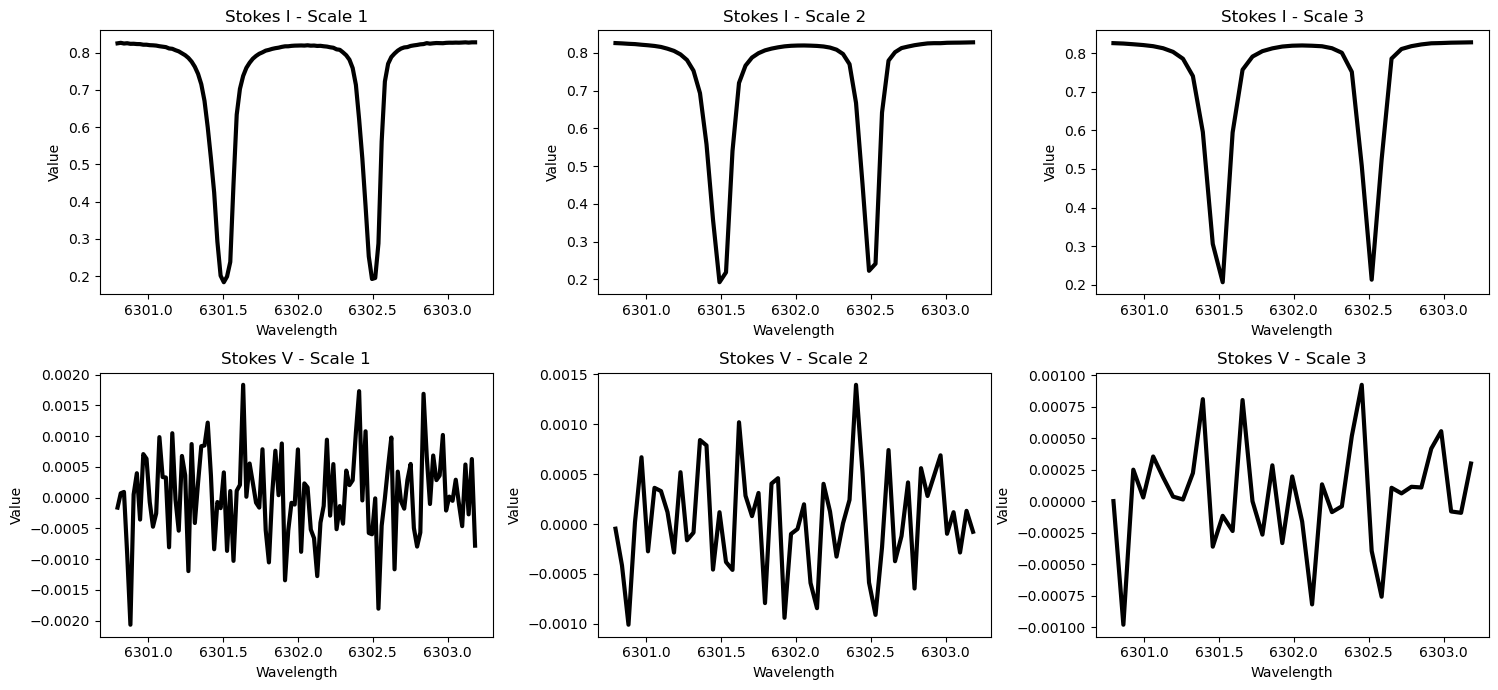

In [12]:
fig, axs = plt.subplots(2, len(scales), figsize=(len(scales)*5, 3.5*2))

stokes_names = ['I', 'V']
for i in range(2):
    for idx, s in enumerate(scales):
        ax = axs[i, idx]
        ax.plot(np.linspace(data_charger.wl_hinode[0], data_charger.wl_hinode[-1], stokes_scales[f"{s}_scale"].shape[-1]), stokes_scales[f"{s}_scale"][0,i,:].cpu(), "k", linewidth=3)
        ax.set_title(f'Stokes {stokes_names[i]} - Scale {s}')
        ax.set_xlabel('Wavelength')
        ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

It is working! Let's create a class that encloses this layer.

In [13]:
class CoarseGrain(nn.Module):
    def __init__(self, scale: int):
        super(CoarseGrain, self).__init__()
        self.scale = scale

    def forward(self, x):
        unfolded = x.unfold(dimension=2, size=self.scale, step=self.scale)
        stokes_scale = unfolded.mean(dim=-1)
        
        return stokes_scale

In [14]:
# Create random input sizes
random_input_image = (1, 2, 112)

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(CoarseGrain(2),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CoarseGrain (CoarseGrain)                [1, 2, 112]          [1, 2, 56]           --                   --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

Apply the same scaling but know using the `CoarseGrain` layer.

In [15]:
stokes_scales = {}
for s in scales:
    coarse_grain_layer = CoarseGrain(scale = s).to(device)
    stokes_scales[f"{s}_scale"] = coarse_grain_layer(stokes_data)
    print(stokes_scales[f"{s}_scale"].size())

torch.Size([3, 2, 112])
torch.Size([3, 2, 56])
torch.Size([3, 2, 37])


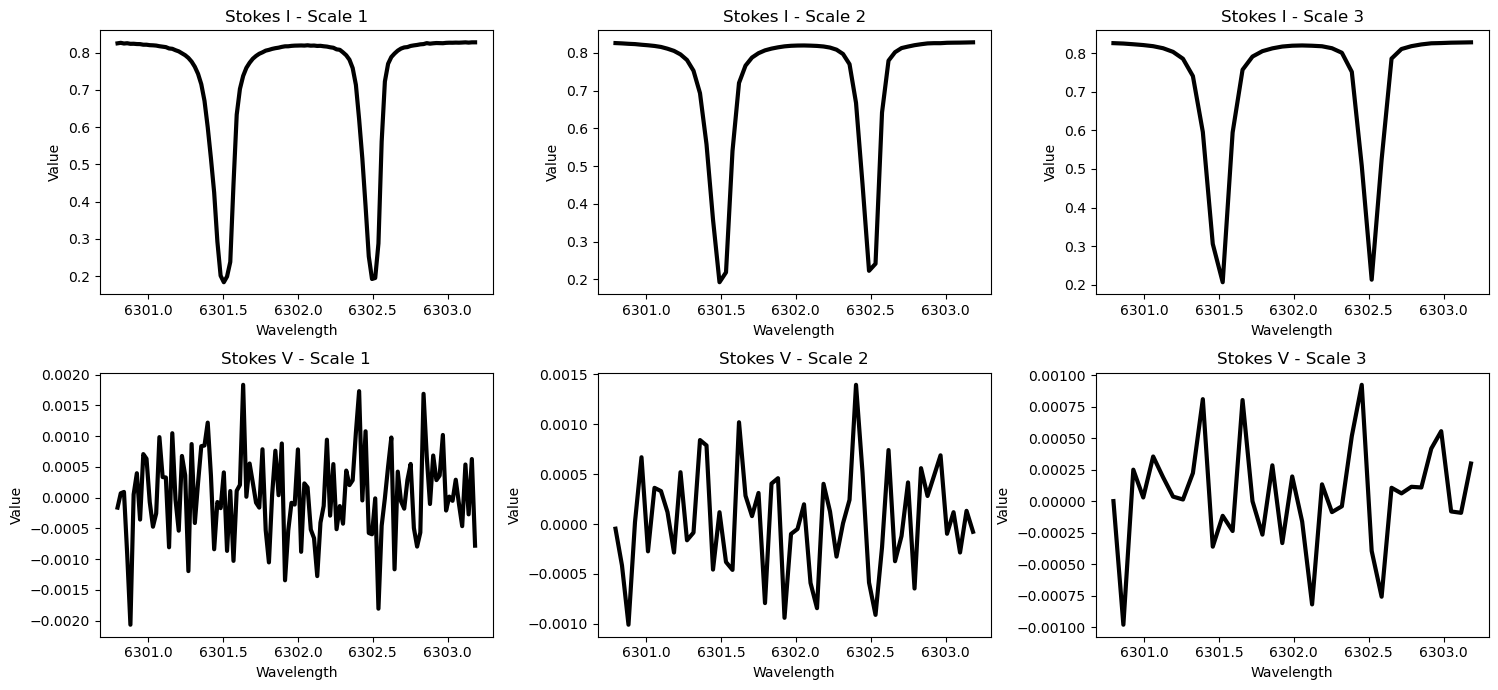

In [16]:
fig, axs = plt.subplots(2, len(scales), figsize=(len(scales)*5, 3.5*2))

stokes_names = ['I', 'V']
for i in range(2):
    for idx, s in enumerate(scales):
        ax = axs[i, idx]
        ax.plot(np.linspace(data_charger.wl_hinode[0], data_charger.wl_hinode[-1], stokes_scales[f"{s}_scale"].shape[-1]), stokes_scales[f"{s}_scale"][0,i,:].cpu(), "k", linewidth=3)
        ax.set_title(f'Stokes {stokes_names[i]} - Scale {s}')
        ax.set_xlabel('Wavelength')
        ax.set_ylabel('Value')

plt.tight_layout()
plt.show()

It is working as expected!

### 2.2 Multi-Scale feature generation

For each coarse-grained signal $\{y^{(s)}\}$ we must apply a convolutional block to encode the signal features.

In [17]:
c1_filters = 16
c2_filters = 32
p = 2
conv_block1 = nn.Sequential(nn.Conv1d(in_channels = 2, out_channels=c1_filters, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.MaxPool1d(kernel_size=p)).to(device)
conv_block2 = nn.Sequential(nn.Conv1d(in_channels = c1_filters, out_channels=c2_filters, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.MaxPool1d(kernel_size=p)).to(device)

Let's try with a sample scale.

In [18]:
conv1_output = conv_block1(stokes_scales[f"{3}_scale"])
conv2_output = conv_block2(conv1_output)
conv1_output.size(), conv2_output.size()

(torch.Size([3, 16, 16]), torch.Size([3, 32, 6]))

Create a class for condensing both layers

In [19]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels: int = 2, c1_filters: int = 16, c2_filters: int = 32, kernel_size: int = 5, stride: int = 1, padding: int = 0, pool_size: int = 2):
        super(ConvBlock, self).__init__()
        self.c1 = nn.Sequential(nn.Conv1d(in_channels = in_channels, out_channels=c1_filters, kernel_size=kernel_size, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.MaxPool1d(kernel_size=p))
        self.c2 = nn.Sequential(nn.Conv1d(in_channels = c1_filters, out_channels=c2_filters, kernel_size=kernel_size, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.MaxPool1d(kernel_size=pool_size))

    def forward(self, x):
        x = self.c1(x)
        x = self.c2(x)
        return x

Let's test it! Aditionally, we will concatenate the feature maps for each scale to get an array of all feature maps

In [20]:
coarse_grains = nn.ModuleDict({f"scale_{s}": CoarseGrain(scale = s) for s in scales})
conv_block = ConvBlock(in_channels=2, c1_filters=16, c2_filters=32, kernel_size=5, stride=1, padding=0, pool_size=2).to(device)

In [21]:
feature_maps_list = []
for s in scales:
    conv_block_output = conv_block(stokes_scales[f"{s}_scale"])
    print(f"Convolutional block output size for scale {s}:", conv_block_output.size())
    feature_maps_list.append(conv_block_output.unsqueeze(0))  # shape: (1, c2_filters, L)

# If all outputs have the same shape, you can concatenate along dim=0 (scale dimension)
feature_maps = torch.cat(feature_maps_list, dim=-1).squeeze(0)  # shape: (len(scales), c2_filters, L)
print("Final feature_maps size:", feature_maps.size())

Convolutional block output size for scale 1: torch.Size([3, 32, 25])
Convolutional block output size for scale 2: torch.Size([3, 32, 11])
Convolutional block output size for scale 3: torch.Size([3, 32, 6])
Final feature_maps size: torch.Size([3, 32, 42])


### 2.3 Multi-Scale feature pipeline

Let's create a class that integrates the coarse-grain operation and the cnn1d feature mapping to create our multiscale feature maps for the following part related to the densely connected layers

In [22]:
class MultiScaleFeatureMapping(nn.Module):
    def __init__(self, scales: list[int], in_channels: int = 2, c1_filters: int = 16, c2_filters: int = 32, kernel_size: int = 5, stride: int = 1, padding: int = 0, pool_size: int = 2):
        super(MultiScaleFeatureMapping, self).__init__()
        self.scales = scales
        self.c2_filters = c2_filters
        self.coarse_grains = nn.ModuleDict({f"scale_{s}": CoarseGrain(scale = s) for s in scales})
        self.conv_block = ConvBlock(in_channels=in_channels, c1_filters=c1_filters, c2_filters=c2_filters, kernel_size=kernel_size, stride=stride, padding=padding, pool_size=pool_size)
        
    def forward(self, x):
        feature_maps = torch.empty((x.size(0), self.c2_filters, 0), dtype=torch.float32, device=x.device)
        for s in self.scales:
            stokes_cg = self.coarse_grains[f"scale_{s}"](x)
            conv_block_output = self.conv_block(stokes_cg)
            feature_maps = torch.cat((feature_maps, conv_block_output), dim=-1)
        return feature_maps
        

In [23]:
multi_scale_feature_mapping = MultiScaleFeatureMapping(scales=scales).to(device)
msfm_output = multi_scale_feature_mapping(stokes_data)
print(msfm_output.size())

torch.Size([3, 32, 42])


All seems to be working right!

## 3. Fully-connected block

For the connection with the fully-connected layer, we must convert the feature maps into a flat one dimensional representation that can be connectedñ.

In [24]:
kernel_size = 5
def get_output_shape(input_size: int, kernel_size: int, stride: int = 1, padding: int = 0) -> int:
    return (input_size - kernel_size + 2 * padding) // stride + 1

pool_stride = 2
total_features = 0
for s in scales:
    conv_output_shapes = stokes_data.size(-1) // s
    for _ in range(2):
        conv_output_shapes = get_output_shape(conv_output_shapes, kernel_size, stride=1, padding=0)//pool_stride 
    total_features += conv_output_shapes
flatten_size = total_features * c2_filters

print("total number of features:", flatten_size)

total number of features: 1344


In [25]:
flatten_layer = nn.Flatten().to(device)
flattened_features = flatten_layer(msfm_output)
print("Flattened features size:", flattened_features.size())

Flattened features size: torch.Size([3, 1344])


Now that we have the correct number of features from the output of the flatten layer, let's create the fully connected block.

In [26]:
linear_layer = nn.Sequential(
    nn.Linear(in_features = flatten_size, out_features = flatten_size),
    nn.ReLU()).to(device)
linear_layers = nn.ModuleList([linear_layer for _ in range(4)]).to(device)
output_layer = nn.Linear(in_features = flatten_size, out_features = 3*21).to(device)

In [27]:
x = flattened_features
for layer in linear_layers:
    x = layer(x)
    print(x.size())

torch.Size([3, 1344])
torch.Size([3, 1344])
torch.Size([3, 1344])
torch.Size([3, 1344])


In [28]:
output = output_layer(x)
output.size()

torch.Size([3, 63])

Let's create a class for the linear block.

In [29]:
class LinearBlock(nn.Module):
    def __init__(self, in_features: int, out_features: int, n_layers: int = 4):
        super(LinearBlock, self).__init__()
        self.layers = nn.ModuleList()
        for _ in range(n_layers):
            self.layers.append(nn.Sequential(
                nn.Linear(in_features=in_features, out_features=in_features),
                nn.ReLU()
            ))
        self.output_layer = nn.Linear(in_features=in_features, out_features=out_features)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.output_layer(x)
        return x

In [30]:
linear_block = LinearBlock(in_features=flatten_size, out_features=3*21, n_layers=4).to(device)
final_output = linear_block(flattened_features)
print("The size of the final output is:", final_output.size())

The size of the final output is: torch.Size([3, 63])


## 4. MSCNN model

Now that we have all the classes with each of the steps of the MSCNN transformations, let's create the model that includes all of them.

In [31]:
class MSCNNInversionModel(nn.Module):
    def __init__(self, scales: list[int], in_channels: int = 2, c1_filters: int = 16, c2_filters: int = 32, kernel_size: int = 5, stride: int = 1, padding: int = 0, pool_size: int = 2, n_linear_layers: int = 4, output_features: int = 3*21):
        super(MSCNNInversionModel, self).__init__()

        # Multi-scale feature mapping
        self.msfm = MultiScaleFeatureMapping(scales=scales, in_channels=in_channels, c1_filters=c1_filters, c2_filters=c2_filters, kernel_size=kernel_size, stride=stride, padding=padding, pool_size=pool_size)
        
        # Calculate flatten size
        total_features = 0
        for s in scales:
            conv_output_shapes = 112 // s  # Assuming input length is 112
            for _ in range(2):
                conv_output_shapes = get_output_shape(conv_output_shapes, kernel_size, stride=1, padding=0)//pool_size 
            total_features += conv_output_shapes
        flatten_size = total_features * c2_filters
        
        self.flatten = nn.Flatten()

        # Linear block
        self.linear_block = LinearBlock(in_features=flatten_size, out_features=output_features, n_layers=n_linear_layers)
        
    def forward(self, x):
        x = self.msfm(x)
        x = self.flatten(x)
        x = self.linear_block(x)
        return x

In [32]:
mscnn_model = MSCNNInversionModel(scales=[1, 2, 3], in_channels=2, c1_filters=16, c2_filters=32, kernel_size=5, stride=1, padding=0, pool_size=2, n_linear_layers=4, output_features=3*21).to(device)
mscnn_output = mscnn_model(stokes_data)
mscnn_output.size()

torch.Size([3, 63])

## 5. MSCNN model from module

We will now check the functionality of the MSCNN model importing it from the module [nn_inversion_model.py](../modules/nn_inversion_model.py)

In [33]:
from modules_2.nn_inversion_model import MSCNNInversionModel
mscnn_model = MSCNNInversionModel(scales=[1, 2, 3], in_channels=2, c1_filters=16, c2_filters=32, kernel_size=5, stride=1, padding=0, pool_size=2, n_linear_layers=4, output_features=3*21).to(device)
mscnn_output = mscnn_model(stokes_data)
mscnn_output.size()

torch.Size([3, 63])